## 🔧 Setup

In [97]:
# 필요한 라이브러리 import
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정 (matplotlib)
# Linux 환경에서 사용 가능한 한글 폰트 찾기
def get_korean_font():
    """시스템에서 사용 가능한 한글 폰트 찾기"""
    korean_fonts = []
    for font in fm.fontManager.ttflist:
        # 한글 폰트 이름 패턴 검색
        font_name = font.name.lower()
        if any(keyword in font_name for keyword in ['nanum', 'noto', 'malgun', 'gothic', 'batang', 'dotum', 'gulim']):
            if 'cjk' in font_name or 'kr' in font_name or font.name.startswith('Nanum'):
                korean_fonts.append(font.name)
    
    # 중복 제거
    return list(set(korean_fonts))

# 한글 폰트 설정 시도
korean_fonts = get_korean_font()
if korean_fonts:
    plt.rcParams['font.family'] = korean_fonts[0]
    print(f"✅ 한글 폰트 설정: {korean_fonts[0]}")
else:
    # 한글 폰트가 없는 경우 기본 설정
    print("⚠️ 한글 폰트를 찾을 수 없습니다.")
    print("다음 명령어로 한글 폰트를 설치하세요:")
    print("  sudo apt-get install fonts-nanum fonts-nanum-coding")
    # 기본 폰트 사용 (한글은 깨질 수 있음)
    plt.rcParams['font.family'] = 'sans-serif'

plt.rcParams['axes.unicode_minus'] = False

# 스타일 설정
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ 라이브러리 import 완료")

⚠️ 한글 폰트를 찾을 수 없습니다.
다음 명령어로 한글 폰트를 설치하세요:
  sudo apt-get install fonts-nanum fonts-nanum-coding
✅ 라이브러리 import 완료


In [98]:
# 환경 변수 로드
load_dotenv(override=True)

# Azure OpenAI 클라이언트 생성
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# 사용할 모델 deployment name
MODEL = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

print(f"✅ Azure OpenAI 클라이언트 설정 완료")
print(f"📦 사용 모델: {MODEL}")

✅ Azure OpenAI 클라이언트 설정 완료
📦 사용 모델: gpt-4.1-mini


## 📊 헬퍼 함수 정의

---

# Part 1: Temperature 🌡️

## 개념

**Temperature**는 LLM 출력의 무작위성(randomness)을 제어합니다.

```
Temperature = 0:
  - 항상 가장 높은 확률의 토큰 선택
  - 결정론적 (deterministic)
  - 일관되고 예측 가능한 출력

Temperature = 1:
  - 모델의 원래 확률 분포 사용
  - 균형잡힌 무작위성

Temperature > 1:
  - 낮은 확률 토큰도 선택될 가능성 증가
  - 창의적이지만 일관성 떨어질 수 있음
```

## 언제 사용하나?

| 값 | 사용 사례 |
|---|---|
| **0 - 0.3** | 사실 기반 답변, 분류, 추출, 번역 |
| **0.7 - 0.9** | 일반적인 대화, 균형잡힌 창의성 |
| **1.0 - 1.5** | 창의적 글쓰기, 브레인스토밍, 스토리텔링 |

In [99]:
prompt = "프랑스의 수도는 어디인가요?"

print("Temperature = 0 (5번 실행)")
print("="*60)

for i in range(5):
    response = call_llm(prompt, temperature=0, max_completion_tokens=300)
    print(f"\n실행 {i+1}: {response}")

Temperature = 0 (5번 실행)



실행 1: 프랑스의 수도는 파리(Paris)입니다.

실행 2: 프랑스의 수도는 파리(Paris)입니다.

실행 3: 프랑스의 수도는 파리(Paris)입니다.

실행 4: 프랑스의 수도는 파리(Paris)입니다.

실행 5: 프랑스의 수도는 파리(Paris)입니다.


## 실습 1.2: Temperature 비교 (0, 0.7, 1.5)

**질문:**
1. 어떤 temperature에서 가장 다양한 응답이 나왔나요?
2. Temperature=1.5의 응답이 이상하거나 일관성이 없나요?
3. 프로젝트에서 어떤 값을 사용하시겠습니까?

/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 51025 (\N{HANGUL SYLLABLE EUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_38691/1947765760.py:12: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  pl

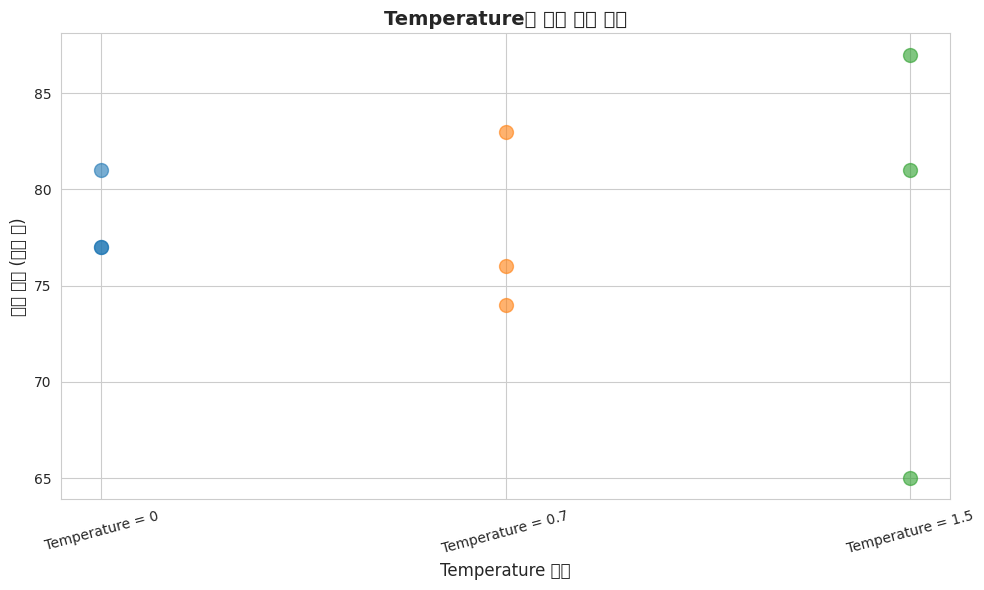


📊 응답 길이 통계:
                   count       mean        std   min   25%   50%   75%   max
설정                                                                          
Temperature = 0      3.0  78.333333   2.309401  77.0  77.0  77.0  79.0  81.0
Temperature = 0.7    3.0  77.666667   4.725816  74.0  75.0  76.0  79.5  83.0
Temperature = 1.5    3.0  77.666667  11.372481  65.0  73.0  81.0  84.0  87.0


In [100]:
# 응답 길이 분포 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for setting in df_temp['설정'].unique():
    subset = df_temp[df_temp['설정'] == setting]
    ax.scatter([setting] * len(subset), subset['길이'], alpha=0.6, s=100)

ax.set_xlabel('Temperature 설정', fontsize=12)
ax.set_ylabel('응답 길이 (문자 수)', fontsize=12)
ax.set_title('Temperature별 응답 길이 분포', fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 통계 요약
print("\n📊 응답 길이 통계:")
print(df_temp.groupby('설정')['길이'].describe())

## 실습 2.1: Top-p 비교

**질문:**
1. Top-p=0.1과 1.0의 차이가 명확한가요?
2. 어떤 경우에 Top-p를 낮게 설정하시겠습니까?

In [112]:
prompt = "3단어로 독특한 회사 이름을 만들어주세요."

params_list = [
    {'name': 'Low Temp (0.3)', 'temperature': 0.3, 'top_p': 1.0, 'max_completion_tokens': 300},
    {'name': 'High Temp (1.5)', 'temperature': 1.5, 'top_p': 1.0, 'max_completion_tokens': 300},
    {'name': 'Low Top-p (0.1)', 'temperature': 1.0, 'top_p': 0.1, 'max_completion_tokens': 300},
    {'name': 'High Top-p (0.95)', 'temperature': 1.0, 'top_p': 0.95, 'max_completion_tokens': 300},
]

df_comparison = compare_responses(prompt, params_list, num_runs=5)
print_comparison(df_comparison)


📌 Low Temp (0.3)

[실행 1] (길이: 92자)
물결빛꿈  
(물결 + 빛 + 꿈을 합쳐서 자연스럽고 희망적인 느낌을 주는 이름입니다.)  

필요하시면 특정 분야나 느낌을 알려주시면 더 맞춤형으로 만들어드릴게요!

[실행 2] (길이: 181자)
물론입니다! 다음은 3단어로 된 독특한 회사 이름 아이디어입니다:

1. **블루문 네트워크 솔루션**  
2. **스파크 윙 크리에이티브**  
3. **루미너스 코어 테크**  
4. **오로라 퓨전 랩**  
5. **넥서스 파이어 스튜디오**

원하는 업종이나 느낌을 알려주시면 더 맞춤형으로 제안해드릴 수 있습니다!

[실행 3] (길이: 6자)
물결별빛코드

[실행 4] (길이: 192자)
물론입니다! 다음과 같은 3단어 회사 이름을 제안드립니다:

1. **블루문 크리에이티브 랩**  
2. **스카이브릿지 테크 솔루션**  
3. **네오파인 스마트 디자인**  
4. **루미너스 코어 인사이트**  
5. **에코웨이브 글로벌 네트워크**

원하는 업종이나 분위기가 있다면 알려주세요. 더 맞춤형으로 만들어드릴 수 있습니다!

[실행 5] (길이: 190자)
물론입니다! 다음은 3단어로 된 독특한 회사 이름 예시입니다:

1. **블루문 네트워크 솔루션**  
2. **스카이브릿지 테크놀로지**  
3. **루미너스 크리에이티브 랩**  
4. **오로라 인사이트 그룹**  
5. **넥스트웨이브 디지털 코퍼레이션**

필요한 업종이나 느낌을 알려주시면 더 맞춤형으로 만들어 드릴 수 있습니다!

📌 High Temp (1.5)

[실행 1] (길이: 8자)
물결 도모 세움

[실행 2] (길이: 32자)
물빛토론  
별길나무  
파동소리  
아래샘물  
바다모래

[실행 3] (길이: 150자)
물론입니다! 다음은 세 단어로 된 독특한 회사 이름 예시입니다:

1. 블루문 크리에이티브 허브  
2. 하늘빛 네트워크 스튜디오  
3. 미디어 팩토리 랩  
4. 스마트컴 인베스트 그룹  
5

## 실습 3.1: Presence Penalty

**관찰:**
- Presence penalty가 높을수록 더 다양한 메뉴가 나왔나요?
- 너무 높으면 이상한 추천이 나오나요?

In [102]:
# 단어 반복이 나타나기 쉬운 프롬프트
prompt = """다음 주제로 3문장을 작성하세요: '인공지능의 중요성'
자연스러운 문장으로 작성해주세요."""

params_list = [
    {'name': 'Frequency Penalty = 0', 'temperature': 0.7, 'frequency_penalty': 0, 'max_completion_tokens': 150},
    {'name': 'Frequency Penalty = 1.0', 'temperature': 0.7, 'frequency_penalty': 1.0, 'max_completion_tokens': 150},
    {'name': 'Frequency Penalty = 2.0', 'temperature': 0.7, 'frequency_penalty': 2.0, 'max_completion_tokens': 150},
]

df_frequency = compare_responses(prompt, params_list, num_runs=2)
print_comparison(df_frequency)


📌 Frequency Penalty = 0

[실행 1] (길이: 121자)
인공지능은 현대 사회에서 다양한 분야의 혁신을 이끄는 핵심 기술입니다. 이를 통해 복잡한 문제를 빠르게 해결하고 효율성을 높일 수 있습니다. 앞으로 인공지능의 발전은 우리의 삶을 더욱 편리하고 풍요롭게 만들 것입니다.

[실행 2] (길이: 145자)
인공지능은 현대 사회에서 빠르게 발전하며 다양한 산업에 혁신을 가져오고 있습니다. 이를 통해 효율성과 생산성이 크게 향상되어 우리의 삶이 더욱 편리해지고 있습니다. 앞으로 인공지능 기술의 중요성은 더욱 커질 것이며, 이에 대한 이해와 활용 능력이 필수적입니다.

📌 Frequency Penalty = 1.0

[실행 1] (길이: 149자)
인공지능은 현대 사회에서 빠르게 발전하며 우리의 생활 방식을 크게 변화시키고 있습니다. 다양한 산업 분야에서 효율성을 높이고 복잡한 문제를 해결하는 데 중요한 역할을 하고 있습니다. 앞으로도 인공지능 기술의 발전은 경제 성장과 혁신을 이끄는 핵심 동력이 될 것입니다.

[실행 2] (길이: 139자)
인공지능은 현대 사회에서 빠르게 발전하며 다양한 산업에 큰 영향을 미치고 있습니다. 이를 통해 복잡한 문제를 효율적으로 해결하고 새로운 가치를 창출할 수 있습니다. 앞으로 인공지능의 역할은 더욱 확대되어 우리의 삶을 편리하고 풍요롭게 만들 것입니다.

📌 Frequency Penalty = 2.0

[실행 1] (길이: 155자)
인공지능은 현대 사회에서 다양한 분야의 문제를 효율적으로 해결하는 데 큰 역할을 하고 있습니다. 또한, 인공지능 기술은 의료, 교육, 산업 등 여러 영역에서 혁신을 이끌어내고 있습니다. 앞으로 인공지능의 발전은 우리의 생활 방식을 더욱 편리하고 안전하게 만들 것으로 기대됩니다.

[실행 2] (길이: 136자)
인공지능은 현대 사회에서 다양한 분야에 혁신을 가져오고 있습니다. 특히 의료, 교육, 산업 등 여러 영역에서 효율성을 높이는 데 큰 역할을 하고 있습니다. 앞으로 인공

---

# Part 4: 기타 파라미터 🔧

In [103]:
prompt = "인공지능의 역사에 대해 설명해주세요."

print("Max Tokens 비교")
print("="*60)

for max_tokens in [20, 50, 100, 200]:
    response = call_llm(prompt, temperature=0.7, max_completion_tokens=max_tokens)
    print(f"\n[Max Tokens = {max_tokens}]")
    print(f"실제 길이: {len(response)} 문자")
    print(response)
    print("-" * 60)

Max Tokens 비교

[Max Tokens = 20]
실제 길이: 56 문자
인공지능(Artificial Intelligence, AI)의 역사는 컴퓨터 과학과 관련된 여러 분야
------------------------------------------------------------

[Max Tokens = 50]
실제 길이: 110 문자
인공지능(AI, Artificial Intelligence)의 역사는 컴퓨터 과학과 수학, 철학 등의 여러 분야가 교차하는 중요한 발전 과정입니다. 아래에 인공지능의 주요 역사적 흐름을 간략히 정리
------------------------------------------------------------

[Max Tokens = 100]
실제 길이: 201 문자
인공지능(Artificial Intelligence, AI)의 역사는 컴퓨터 과학과 관련된 여러 학문 분야의 발전과 함께 시작되었으며, 대략 다음과 같은 주요 시기와 사건들로 구분할 수 있습니다.

1. **초기 개념과 배경 (1940~1950년대)**
   - 인공지능의 기초는 앨런 튜링(Alan Turing)의 연구에서 시작되었습니다. 1950년에 발표된
------------------------------------------------------------

[Max Tokens = 200]
실제 길이: 430 문자
인공지능(AI, Artificial Intelligence)의 역사는 컴퓨터 과학과 수학, 신경과학 등 여러 분야의 발전과 함께 시작되었습니다. 인공지능의 발전 과정은 여러 단계와 중요한 사건들로 나뉘며, 주요 내용을 아래와 같이 정리할 수 있습니다.

### 1. 초기 개념과 이론적 기반 (1940~1950년대)
- **앨런 튜링(Alan Turing)**: 1950년에 발표한 논문 "Computing Machinery and Intelligence"에서 '튜링 테스트'라는 개념을 제시하며, 기계가 인간처럼 사고할 수 있는지에 대

## 4.2 Seed (재현성)

**언제 사용하나?**
- 테스트 시 재현 가능한 결과 필요
- 디버깅
- A/B 테스트에서 공정한 비교

**⚠️ 주의**: Seed를 설정해도 100% 동일하지 않을 수 있습니다 (서버 환경, 모델 업데이트 등)

In [104]:
# JSON 출력 요청
prompt = """다음 정보를 JSON 형식으로 추출하세요:

홍길동은 30세이며 서울에 거주합니다. 직업은 소프트웨어 엔지니어이고 취미는 등산입니다.

JSON 키: name, age, city, job, hobby
"""

print("일반 모드")
print("="*60)
response_normal = call_llm(prompt, temperature=0)
print(response_normal)

print("\n\nJSON 모드")
print("="*60)
response_json = client.chat.completions.create(
    model=MODEL,
    response_format={"type": "json_object"},
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0
)
json_output = response_json.choices[0].message.content
print(json_output)

# JSON 파싱 테스트
try:
    parsed = json.loads(json_output)
    print("\n✅ JSON 파싱 성공!")
    print(f"이름: {parsed.get('name')}")
    print(f"나이: {parsed.get('age')}")
except json.JSONDecodeError as e:
    print(f"\n❌ JSON 파싱 실패: {e}")

일반 모드
```json
{
  "name": "홍길동",
  "age": 30,
  "city": "서울",
  "job": "소프트웨어 엔지니어",
  "hobby": "등산"
}
```


JSON 모드
{
  "name": "홍길동",
  "age": 30,
  "city": "서울",
  "job": "소프트웨어 엔지니어",
  "hobby": "등산"
}

✅ JSON 파싱 성공!
이름: 홍길동
나이: 30


---

# Part 5: Best-of-N Sampling 🏆

## 개념

**Best-of-N**: 여러 개(N개)의 답변을 생성하고 가장 좋은 것을 선택

```
방법 1: n 파라미터 (한 번에 여러 답변)
  - API 호출 1회
  - 비용 효율적
  
방법 2: 여러 번 호출
  - API 호출 N회
  - 더 많은 제어 가능
```

## Trade-off

- **장점**: 품질 향상
- **단점**: 비용 증가 (N배), 시간 증가

In [105]:
prompt = "AI 스타트업을 위한 독창적인 회사 이름을 하나 제안해주세요. (3단어 이내)"

# n=5로 5개 답변 생성
response = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "user", "content": prompt}],
    temperature=1.0,
    n=5,
    max_completion_tokens=30
)

print("생성된 5개 답변:")
print("="*60)
for i, choice in enumerate(response.choices, 1):
    print(f"{i}. {choice.message.content}")

print("\n❓ 질문: 어떤 답변이 가장 좋은가요? 왜 그렇게 생각하나요?")

생성된 5개 답변:
1. NeuronWave Labs
2. NeuraWave Labs
3. NeuraSpark Labs
4. 넥스브레인 (NexBrain)
5. NeuraShift Labs

❓ 질문: 어떤 답변이 가장 좋은가요? 왜 그렇게 생각하나요?


In [106]:
prompt = "인공지능의 윤리적 문제 3가지를 간단히 설명해주세요."

response = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "user", "content": prompt}],
    temperature=0.8,
    n=3,
    max_completion_tokens=200
)

# 모든 답변과 길이 출력
print("생성된 답변들:")
print("="*60)
answers = []
for i, choice in enumerate(response.choices, 1):
    content = choice.message.content
    length = len(content)
    answers.append((content, length))
    print(f"\n답변 {i} (길이: {length}):\n{content}")

# 가장 긴 답변 선택 (상세한 설명)
best_answer = max(answers, key=lambda x: x[1])
print("\n" + "="*60)
print("🏆 선택된 답변 (가장 상세함):")
print("="*60)
print(best_answer[0])

생성된 답변들:

답변 1 (길이: 273):
물론입니다! 인공지능의 윤리적 문제 3가지는 다음과 같습니다:

1. **편향성과 차별**  
   인공지능이 학습하는 데이터에 편향이 있을 경우, 결과도 특정 인종, 성별, 계층 등에 불공정하게 작용할 수 있습니다.

2. **프라이버시 침해**  
   인공지능이 개인정보를 대량으로 수집·분석하면서 개인의 사생활이 침해될 위험이 있습니다.

3. **책임 소재 불명확**  
   인공지능의 판단이나 행동으로 문제가 발생했을 때, 누가 책임져야 하는지 명확하지 않은 경우가 많습니다.

답변 2 (길이: 290):
인공지능의 윤리적 문제 3가지는 다음과 같습니다:

1. **편향성과 차별**  
AI가 학습하는 데이터에 편향이 있을 경우, 그 결과도 편향되어 특정 집단에 불리한 결정이나 차별을 초래할 수 있습니다.

2. **프라이버시 침해**  
AI가 대량의 개인 데이터를 수집하고 분석하면서 개인 정보가 유출되거나 사생활이 침해될 위험이 있습니다.

3. **책임 소재 불분명**  
AI가 잘못된 결정을 내렸을 때, 그 책임이 개발자, 사용자, 혹은 AI 자체 중 누구에게 있는지 명확하지 않아 문제를 일으킬 수 있습니다.

답변 3 (길이: 303):
물론입니다! 인공지능의 윤리적 문제 3가지는 다음과 같습니다:

1. **편향과 차별**  
   인공지능이 학습하는 데이터에 편향이 있을 경우, 결과도 특정 인종, 성별, 계층 등에 대해 차별적인 결정을 내릴 수 있습니다.

2. **프라이버시 침해**  
   AI가 대량의 개인 정보를 수집하고 분석하면서 개인의 사생활이 침해될 위험이 커집니다.

3. **책임 소재 불명확**  
   AI가 잘못된 판단이나 사고를 일으켰을 때, 이를 만든 개발자, 사용자, 또는 AI 자체 중 누가 책임을 져야 하는지 명확하지 않은 문제가 있습니다.

🏆 선택된 답변 (가장 상세함):
물론입니다! 인공지능의 윤리적 문제 3가지는 다음과 같습니다:

1. **편향과 차별**  

In [107]:
prompt = "기후 변화에 대한 한 문단 설명을 작성해주세요."

# 3개 답변 생성
response = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "user", "content": prompt}],
    temperature=0.9,
    n=3,
    max_completion_tokens=150
)

answers = [choice.message.content for choice in response.choices]

# 각 답변 평가 (LLM을 judge로 사용)
scores = []
for i, answer in enumerate(answers, 1):
    eval_prompt = f"""다음 답변을 1-10점으로 평가하세요.
평가 기준: 정확성, 명확성, 완성도

답변:
{answer}

점수만 숫자로 답하세요 (예: 8):"""
    
    score_response = call_llm(eval_prompt, temperature=0, max_completion_tokens=5)
    try:
        score = int(score_response.strip())
        scores.append(score)
        print(f"답변 {i} 점수: {score}/10")
        print(f"내용: {answer[:100]}...\n")
    except:
        scores.append(0)
        print(f"답변 {i} 점수 파싱 실패\n")

# 최고 점수 답변 선택
best_idx = scores.index(max(scores))
print("="*60)
print(f"🏆 최고 점수 답변 (답변 {best_idx + 1}):")
print("="*60)
print(answers[best_idx])

답변 1 점수: 9/10
내용: 기후 변화는 지구의 평균 기온이 장기적으로 변하는 현상을 의미하며, 주로 인간 활동에 의해 대기 중 온실가스 농도가 증가하면서 발생합니다. 이로 인해 극심한 기상 현상, 해수면 상...

답변 2 점수: 9/10
내용: 기후 변화는 지구의 평균 기온이 장기적으로 상승하거나 하강하는 현상을 의미하며, 주로 인간 활동에 의해 대기 중 온실가스 농도가 증가하면서 발생합니다. 이로 인해 극심한 기상 이변...

답변 3 점수: 8/10
내용: 기후 변화는 지구의 평균 기온이 장기적으로 상승하거나 변동하는 현상을 의미하며, 주로 온실가스 배출 증가에 의해 발생합니다. 산업화 이후 화석 연료의 사용이 급격히 늘어나면서 이산...

🏆 최고 점수 답변 (답변 1):
기후 변화는 지구의 평균 기온이 장기적으로 변하는 현상을 의미하며, 주로 인간 활동에 의해 대기 중 온실가스 농도가 증가하면서 발생합니다. 이로 인해 극심한 기상 현상, 해수면 상승, 생태계 교란 등 다양한 환경 문제와 사회·경제적 영향을 초래하고 있습니다. 기후 변화를 완화하기 위해서는 탄소 배출 감축, 재생에너지 확대, 지속 가능한 생활 방식 채택 등이 중요하며, 전 세계적인 협력과 정책적 노력이 요구됩니다.


---

# Part 6: 종합 실습 💼

In [108]:
# 추천 설정: Temperature=0, 일관된 분류 필요

customer_query = """제품이 3일 전에 주문했는데 아직 도착하지 않았어요. 
배송 추적이 가능한가요?"""

classification_prompt = f"""다음 고객 문의를 분류하세요.
카테고리: 배송문의, 제품문의, 환불요청, 기타

고객 문의: {customer_query}

카테고리만 답하세요:"""

# 여러 번 실행해도 같은 결과
print("Temperature = 0 (일관된 분류)")
for i in range(5):
    result = call_llm(classification_prompt, temperature=0, max_completion_tokens=20)
    print(f"실행 {i+1}: {result}")

Temperature = 0 (일관된 분류)
실행 1: 배송문의
실행 2: 배송문의
실행 3: 배송문의
실행 4: 배송문의
실행 5: 배송문의


In [109]:
# 추천 설정: Temperature=0.9-1.2, n=5 (Best-of-N)

product_info = "친환경 대나무 칫솔, 생분해 가능, 부드러운 모"

copy_prompt = f"""제품을 위한 짧고 감각적인 마케팅 문구를 만들어주세요.

제품: {product_info}

한 문장으로 작성해주세요:"""

response = client.chat.completions.create(
    model=MODEL,
    messages=[{"role": "user", "content": copy_prompt}],
    temperature=1.1,
    n=5,
    max_completion_tokens=300
)

print("생성된 마케팅 카피 (5개):")
print("="*60)
for i, choice in enumerate(response.choices, 1):
    print(f"{i}. {choice.message.content}\n")

생성된 마케팅 카피 (5개):
1. 자연을 닮은 부드러움, 친환경 대나무 칫솔로 깨끗한 미소를 지켜요.

2. 자연을 닮은 부드러움, 생분해 가능한 친환경 대나무 칫솔로 상쾌한 하루를 시작하세요.

3. 자연을 담은 부드러움, 생분해 가능한 친환경 대나무 칫솔로 상쾌한 미소를 지으세요.

4. 자연을 닮은 부드러움, 친환경 대나무 칫솔로 하루를 상쾌하게.

5. "자연을 생각하는 순간, 부드러운 대나무 칫솔로 깨끗함을 선물하세요."



In [110]:
# 추천 설정: Frequency penalty=0.5-1.0, Presence penalty=0.5

blog_prompt = """블로그 글을 작성하세요.

주제: AI가 일상생활을 어떻게 변화시키고 있는가
길이: 3-4개 문단
톤: 친근하고 이해하기 쉽게
"""

print("Penalty 없음")
print("="*60)
no_penalty = call_llm(
    blog_prompt,
    temperature=0.7,
    max_completion_tokens=400
)
print(no_penalty)

print("\n\nPenalty 있음")
print("="*60)
with_penalty = call_llm(
    blog_prompt,
    temperature=0.7,
    frequency_penalty=0.8,
    presence_penalty=0.5,
    max_completion_tokens=400
)
print(with_penalty)

Penalty 없음
요즘 우리 일상 곳곳에서 ‘AI(인공지능)’이라는 말을 자주 듣게 되죠. AI는 이제 단순한 미래 기술이 아니라, 이미 우리 생활에 깊숙이 들어와 많은 변화를 만들어내고 있어요. 예를 들어, 스마트폰의 음성 비서나 추천 알고리즘 덕분에 원하는 정보를 더 빠르고 쉽게 찾을 수 있게 되었고, 집안에서는 AI 스피커가 날씨를 알려주거나 음악을 틀어주며 생활을 편리하게 만들어주고 있답니다.

또한, 쇼핑할 때도 AI의 영향력을 느낄 수 있어요. 내가 자주 보는 상품이나 관심 있는 스타일을 분석해 맞춤형 추천을 해주니까, 원하는 물건을 찾는 시간이 훨씬 줄어들었죠. 심지어 AI는 교통 상황을 실시간으로 파악해 최적의 경로를 안내해주기 때문에 출퇴근길 스트레스도 많이 줄어들고 있어요. 이처럼 AI는 우리의 생활 패턴을 보다 효율적이고 스마트하게 바꾸어 가고 있답니다.

앞으로는 더 다양한 분야에서 AI가 활약할 텐데요, 건강 관리나 교육, 취미 생활까지 AI가 함께한다면 일상이 더 풍요롭고 즐거워질 거예요. 물론 AI가 모든 걸 대신해주는 것은 아니지만, 우리 삶을 더 편리하고 재미있게 만들어 주는 든든한 동반자라는 점은 분명하답니다. 앞으로 AI와 함께하는 일상이 어떻게 변화할지 기대가 되네요!


Penalty 있음
요즘 우리 일상에서 AI(인공지능)의 영향력을 빼놓고 이야기하기 어려울 정도로 많은 변화가 일어나고 있어요. 예전에는 SF 영화 속 이야기 같았던 음성 인식 비서, 자동 번역기, 맞춤형 추천 서비스 등이 이제는 우리 생활 곳곳에 자연스럽게 스며들어 있답니다. 스마트폰에서 “오늘 날씨 어때?”라고 물으면 바로 답해주고, 좋아하는 음악을 알아서 틀어주는 AI 덕분에 우리는 더 편리하고 풍부한 경험을 누리고 있죠.

특히 쇼핑이나 콘텐츠 소비 방식도 크게 달라졌어요. 온라인 쇼핑몰에서는 내가 이전에 관심을 가졌던 상품들을 분석해 딱 맞는 추천 상품을 보여주고, 넷플릭스나 유튜브 같은 플랫폼은 내 취향에 꼭 맞는 드라마나 영상을 골라줘요. 이

In [111]:
# 추천 설정: Temperature=0, JSON mode, Seed (테스트 시)

text = """김철수 고객님께서 2024년 1월 10일에 노트북(모델명: XPS-15)을 
1,500,000원에 구매하셨습니다. 배송 주소는 서울시 강남구이며, 
연락처는 010-1234-5678입니다."""

extraction_prompt = f"""다음 텍스트에서 정보를 추출하여 JSON으로 반환하세요.

텍스트: {text}

추출할 정보:
- customer_name (고객명)
- date (구매일, YYYY-MM-DD)
- product (제품명)
- price (가격, 숫자만)
- address (주소)
- phone (전화번호)

JSON으로만 답하세요:"""

response = client.chat.completions.create(
    model=MODEL,
    response_format={"type": "json_object"},
    messages=[{"role": "user", "content": extraction_prompt}],
    temperature=0,
    seed=42
)

result = json.loads(response.choices[0].message.content)

print("추출된 데이터:")
print("="*60)
print(json.dumps(result, indent=2, ensure_ascii=False))

추출된 데이터:
{
  "customer_name": "김철수",
  "date": "2024-01-10",
  "product": "노트북 (모델명: XPS-15)",
  "price": 1500000,
  "address": "서울시 강남구",
  "phone": "010-1234-5678"
}


## 파라미터 치트시트

| 사용 사례 | Temperature | Top-p | Penalty | Max Tokens | 기타 |
|----------|-------------|-------|---------|-----------|------|
| **분류/추출** | 0-0.3 | 1.0 | 0 | 적게 | Seed ✓ |
| **사실 기반 Q&A** | 0-0.3 | 1.0 | 0 | 중간 | - |
| **일반 대화** | 0.7-0.9 | 1.0 | 0 | 중간 | - |
| **창의적 글쓰기** | 1.0-1.5 | 0.9 | 0 | 많이 | - |
| **긴 콘텐츠** | 0.7 | 1.0 | 0.5-1.0 | 많이 | - |
| **JSON 출력** | 0 | 1.0 | 0 | - | JSON mode |
| **마케팅 카피** | 1.0 | 0.9 | 0 | 적게 | n=5 |

## Best Practices

1. **시작은 간단하게**: Temperature=0.7, 다른 파라미터는 기본값
2. **한 번에 하나씩**: Temperature 또는 Top-p 중 하나만 조정
3. **반복 문제**: Frequency penalty 먼저, 그래도 안 되면 Presence
4. **비용 관리**: Max tokens로 제한, 불필요한 n 사용 자제
5. **테스트**: Seed로 재현 가능하게, 여러 예시로 검증

## 다음 단계

이제 여러분의 프로젝트에 적용해보세요!

1. 사용 사례 정의
2. 위 치트시트에서 시작점 찾기
3. 테스트 세트로 실험
4. 미세 조정
5. 비용/품질 균형 찾기

---

# 🎉 수고하셨습니다!

이제 여러분은:

✅ Temperature로 출력의 무작위성을 제어할 수 있습니다

✅ Top-p로 토큰 선택 범위를 조정할 수 있습니다

✅ Penalty로 반복을 방지할 수 있습니다

✅ JSON mode로 구조화된 출력을 생성할 수 있습니다

✅ Best-of-N으로 품질을 향상시킬 수 있습니다

✅ 사용 사례에 맞는 최적 파라미터를 선택할 수 있습니다

**다음 실습**: RAG (Retrieval-Augmented Generation) 🚀